### Comparing the Color of Quasars

Jenny Kim, Phil Marshall

[This file](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv) contains SDSS quasar magnitudes and redshifts. With the lenspop library, we could compute the synthetic magnitudes in g, r, i, and z filter of the quasar samples in the file. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude between the known SDSS values and the colored magnitudes for each quasar sample.

### Requirements

SDSS data(can be downloaded [here](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv)), packages that help reading and writing the data, [color_demo](https://github.com/jennykim1016/OM10/blob/master/notebooks/color_demo.py) to synthetically color the quasars.

In [72]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import color_demo
import pandas as pd
import corner
from astropy.table import Table
import numpy as np
from om10 import plotting
from astropy.io import ascii
import om10
sns.set()
pd.set_option('display.max_columns', None)

In [74]:
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
db.select_random(Nlens=200,maglim=19.5)
db.paint(synthetic=True, target='source')

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 200 lenses
OM10: Wrote catalog of 200 OM10 lenses to file at /Users/Jenny/Desktop/om10fork/om10/data/qso_sample_source_colored.fits
OM10: Full db.lenses table contains 200 systems
OM10: Initial db.sample contains 200 systems


`db.paint` method takes a while to compute the magnitude of 200 lenses. Thus, if we want, we can save the file by using the method:

`db.write_table('/Users/Jenny/Desktop/om10fork/om10/data/qso_sample_source_colored.fits')`

and next time, when we are reusing the data, we can call :

`db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_sample_source_colored.fits')`

After finishing the cross-checking with various different data sets, we can override `qso_mock.fits` with six more columns - u, g, r, i, z, and y.

Let's read in the catalog through pd(panda) and remove any outliers. The key values for the [qso10000](../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv") files are the followings: 

`objid,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z`.

In [75]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
qso = qsos.as_matrix()

We initialize the array for redshift, $i$-magnitude, $G-R$ magnitude, $R-I$ magnitude, and $I-Z$ magnitude. Then, we select 50 random numbers from 0 to length of qso array, painting them with the color_demo file which extends lenspop library to compute the synthetic magnitude.

Then, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses.

In addition to this, we can use rejection sampling method to make the distribution more like its gaussian population distribution.

Reweighting algorithm is implemented in `gaussian_reweight`.

In [76]:
matplotlib.rc('text', usetex=False)
zReal = qsos["spec_z"].as_matrix()

db.gaussian_reweight(np.mean(zReal), np.std(zReal))

Draw the cornerplot with the synthetically colored OM10 lenses. We can use `%%capture` to suppress the automatic display of the cornerplot.

In addition, om10 uses usetex=True, which sometimes generates error when using matplotlib. To be safe, let's disable usetex by doing the command `matplotlib.rc('text', usetex=False)`.

In [77]:
%%capture
matplotlib.rc('text', usetex=False)
# calculate the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS'] - db.sample['r_SDSS']
ri = db.sample['r_SDSS'] - db.sample['i_SDSS']
iz = db.sample['i_SDSS'] - db.sample['z_SDSS']
data = Table({'i_SDSS': db.sample['i_SDSS'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

Get the original SDSS data of $i$-magnitudes, redshifts, $G-R$ magnitudes, $R-I$ magnitudes, and $I-Z$ magnitudes as an array. Remove outliers based on the redshift and the $i$-magnitude. 

In [78]:
iReal = qsos["mag_i"].as_matrix()
grReal = qsos["g_r_color"].as_matrix()
riReal = qsos["r_i_color"].as_matrix()
izReal = qsos["i_z_color"].as_matrix()

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

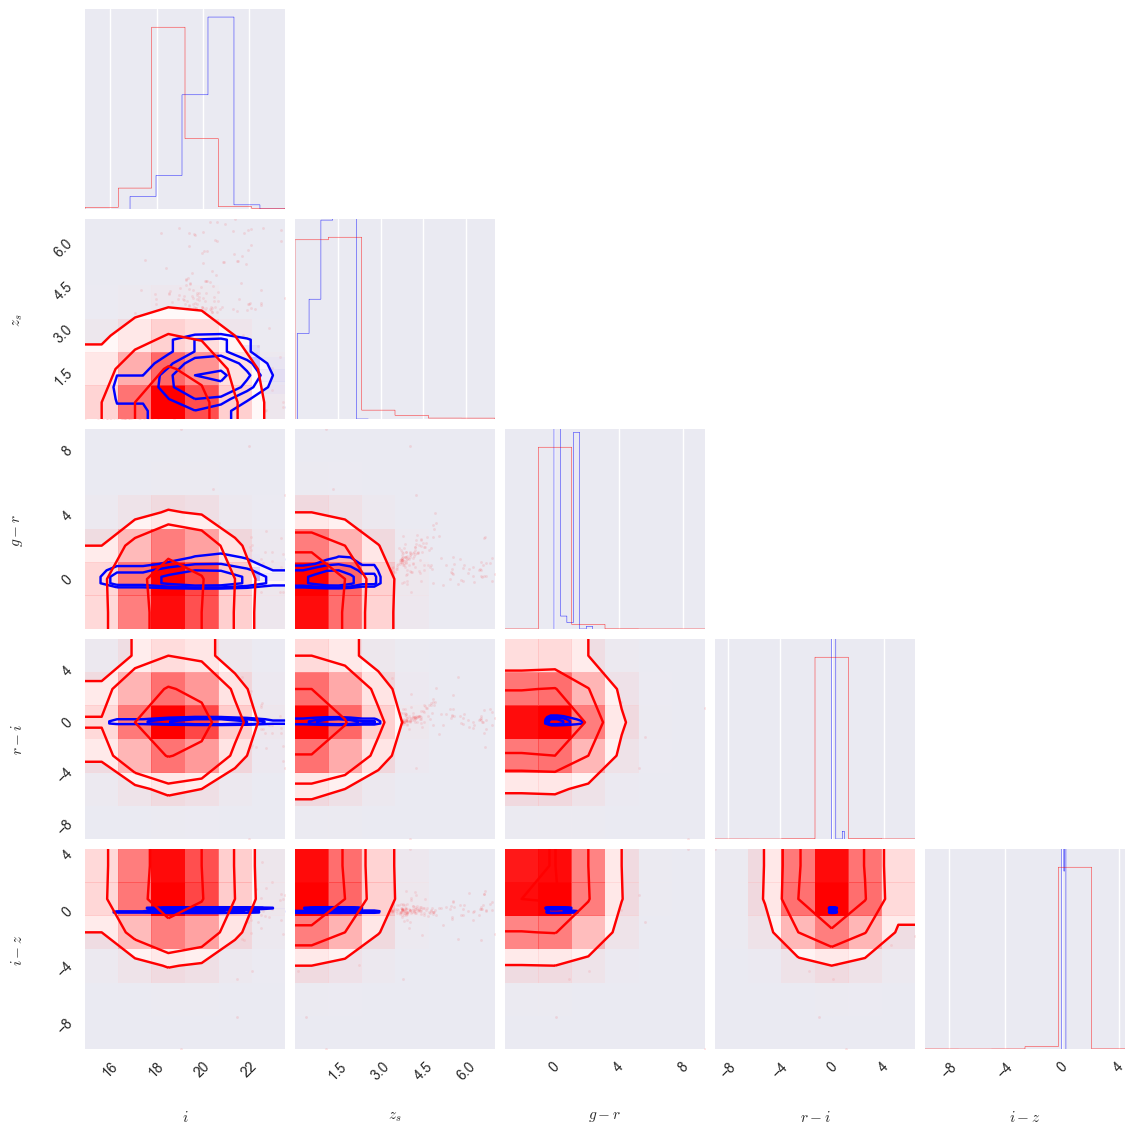

In [79]:
matplotlib.rc('text', usetex=False)
data = Table({'MAGI_Q': iReal, 'ZSRC': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.3, hist_kwargs=dict(normed=True), fig=fig1)

### Discussion

Red(the real data) seems to have wider distribution than the blue(synthetically colored data). This is because of the sample size. Red data is a plot that reflects the distribution of 10,000 quasars, whereas blue only represents 200 quasars. The cornerplot suggests that the red(the real data) and the blue(synthetically colored data) mostly have similar average values. Histogram matched pretty well with each other.